In [1]:
import pandas as pd 
import numpy as np
import random
import datetime
import sklearn.linear_model as skl_lm
import matplotlib.pyplot as plt 
import utilities as utils
import fractionalDiff as fd

In [2]:
pd.read_excel('./data/returnsToWide.xlsx')

,Unnamed: 0,date,weekDay,AUDUSD,EURAUD,EURJPY,EURUSD,GBPUSD,USDJPY
0,0,2021-05-11,1,-0.000151,0.000272,0.014008,-0.000100,0.000100,-0.004005
1,1,2021-05-12,2,0.000170,-0.000200,-0.057999,0.000165,0.000336,-0.058998
2,2,2021-05-13,3,0.000230,0.000100,-0.008011,-0.000292,0.000395,-0.002998
3,3,2021-05-16,6,0.000212,-0.000470,0.026001,0.000280,0.000179,0.000000
4,4,2021-05-17,0,0.000020,0.000050,-0.026993,0.000163,0.000020,-0.034004
...,...,...,...,...,...,...,...,...,...
257,257,2022-05-05,3,0.000000,0.000000,0.000000,0.000000,-0.000229,0.000000
258,258,2022-05-08,6,0.000000,0.000000,0.000000,0.000000,-0.000228,0.000000
259,259,2022-05-09,0,0.000000,0.000000,0.000000,0.000000,0.000396,0.000000
260,260,2022-05-10,1,0.000000,0.000000,0.000000,0.000000,0.000167,0.000000


In [3]:
nSim = 10
accuracies = []
pTrain = 0.7

inputs = pd.read_excel('./data/returnsToWide.xlsx')
logicOutputs = pd.read_excel('./data/logisticOutputs.xlsx')
tickers = ['EURJPY', 'EURUSD', 'EURAUD', 'USDJPY', 'GBPUSD', 'AUDUSD']

pTrain = 0.7
window = 20 #I noticed window = 20 gives a maximum of test dataset accuracy
cutoff = 1e-3

orders = np.linspace(.4, .9, 10)
order = 0.3

scoresByOrderLst = []

for order in orders:
    print(f'Differencing order: {order}')

    lags = fd.findCutoff(order,cutoff,1)
    transformedInputs = fd.TransformInputs(inputs, tickers, order = order, thresholdVal = cutoff)[lags:]

    scoresLst = []
    window_0 = 14
    deltaWindow = 0
    
    ######################################### window loop starts #########################################
    for window in range(window_0, window_0 + deltaWindow + 1):
        print(f'Temporal window window: {window}')
        trainScores = []
        testScores = []

        scoresWithTickersLst = []
        for ticker in tickers:

            for stopDate in inputs.date[window:(inputs.date.shape[0])]:
                
                startDate = stopDate + datetime.timedelta(days=-(window)+1)

                x, y = utils.PrepareInputs(transformedInputs, logicOutputs[lags:], startDate, stopDate, ticker)
                
                nTrain = int(pTrain * x.shape[0])
                nanIdx = np.sum(np.isnan(x), axis = 1)
                x = np.nan_to_num(x)
                
                xTrain, xTest, yTrain, yTest = utils.TestTrainSplit(x, y, nTrain)
                
                if len(np.unique(yTrain)) < 2:
                    continue

                lrm = skl_lm.LogisticRegression(random_state=0, verbose = 0).fit(xTrain, yTrain)
                trainScores.append(lrm.score(xTrain, yTrain))
                testScores.append(lrm.score(xTest, yTest))

            scoresWithTickers = pd.DataFrame(np.array([trainScores, testScores]).T, columns = ['train', 'test'])
            scoresWithTickers['ticker'] = ticker 
            scoresWithTickersLst.append(scoresWithTickers)

    #################################################### window loop ends #######################################################################

        scores = pd.concat(scoresWithTickersLst)
        scores['window'] = window
        scoresLst.append(scores)

    scoresDf = pd.concat(scoresLst)
    scoresDf['order'] = order
    scoresByOrderLst.append(scoresDf)

scoresByOrder = pd.concat(scoresByOrderLst)

Differencing order: 0.4
Temporal window window: 14
Differencing order: 0.4555555555555556
Temporal window window: 14
Differencing order: 0.5111111111111111
Temporal window window: 14
Differencing order: 0.5666666666666667
Temporal window window: 14
Differencing order: 0.6222222222222222
Temporal window window: 14
Differencing order: 0.6777777777777778
Temporal window window: 14
Differencing order: 0.7333333333333334
Temporal window window: 14
Differencing order: 0.7888888888888889
Temporal window window: 14
Differencing order: 0.8444444444444444
Temporal window window: 14
Differencing order: 0.9
Temporal window window: 14


In [4]:
aggScores = scoresByOrder.groupby(['order', 'window']).agg({'train':[np.median, np.std], 'test':[np.median, np.std]}).droplevel(level=[0], axis = 1).reset_index()
aggScores.columns = ['order', 'window', 'trainMedian', 'trainStd', 'testMedian', 'testStd']

aggScores

,order,window,trainMedian,trainStd,testMedian,testStd
0,0.400000,14,1.0,0.079435,0.500000,0.297712
1,0.455556,14,1.0,0.078784,0.666667,0.295299
2,0.511111,14,1.0,0.078729,0.666667,0.293003
3,0.566667,14,1.0,0.080534,0.666667,0.294806
4,0.622222,14,1.0,0.079915,0.666667,0.294702
5,0.677778,14,1.0,0.080610,0.666667,0.291855
6,0.733333,14,1.0,0.081645,0.666667,0.291712
7,0.788889,14,1.0,0.083387,0.666667,0.292700
8,0.844444,14,1.0,0.082648,0.666667,0.290463
9,0.900000,14,1.0,0.081290,0.666667,0.293052


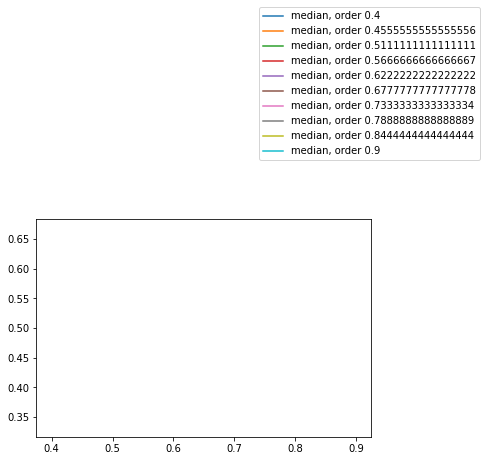

In [92]:
# for order in orders:
dataToPlot = aggScores.loc[aggScores.order == order].copy()

for ord in aggScores.order.unique():
    plt.plot(aggScores.loc[aggScores.order == ord].order, aggScores.loc[aggScores.order == ord].testMedian, label = f'median, order {ord}')
    #plt.plot(aggScores.loc[aggScores.window == win].order, aggScores.loc[aggScores.window == win].testStd, label = f'std, window {win}')
    plt.legend(bbox_to_anchor =(0.65, 1.25))

plt.show()

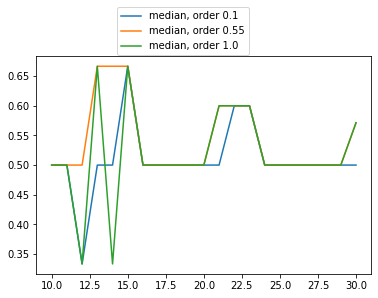

In [57]:
# for order in orders:
dataToPlot = aggScores.loc[aggScores.order == order].copy()

for ord in aggScores.order.unique():
    plt.plot(aggScores.loc[aggScores.order == ord].window, aggScores.loc[aggScores.order == ord].testMedian, label = f'median, order {ord}')
    #plt.plot(aggScores.loc[aggScores.window == win].order, aggScores.loc[aggScores.window == win].testStd, label = f'std, window {win}')
    plt.legend(bbox_to_anchor =(0.65, 1.25))

plt.show()

In [61]:
aggScores.to_excel('data/aggScoresFracDiffGroups_2nomial.xlsx', engine = 'openpyxl')